In [1]:
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir(".."))

['.ipynb_checkpoints', '38bc8193f67c1cfb8b2a413871425806.png', 'Android', 'Bayu Arif Budiman - Resume.pdf', 'Data diri', 'Final Project', 'Heart-Disease-Classification', 'NLP', 'sign_mnist_test', 'sign_mnist_train', 'Verbal-Reasoning-Test1-Solutions.pdf']


In [119]:
#data1 = open('amazon_cells_labelled.txt')
#data1 = data1.read()
#data1
df_imdb = pd.read_csv("amazon_cells_labelled.txt", sep="\t",header=None,names=['Review','Value'])
df_imdb

,Review,Value
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [134]:
print(sum(df_imdb['Value'])) #equally mixed data


#seluruh kalimat
regex = r'[^a-z\s]'

# Ubah seluruh huruf dalam data artikel ke dalam lower case
df_imdb['Review'] = df_imdb['Review'].str.lower()

# Hapus seluruh simbol yang ada dan ganti dengan string kosong ('')
df_imdb['Review'] = df_imdb['Review'].str.replace(regex,'')

df_imdb

500


,Review,Value
0,so there is no way for me to plug it in here i...,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more...,0
4,the mic is great,1
...,...,...
995,the screen does get smudged easily because it ...,0
996,what a piece of junk i lose more calls on this...,0
997,item does not match picture,0
998,the only thing that disappoint me is the infra...,0


In [141]:
import tensorflow as tf
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import model_from_json, load_model

# Lakukan import fungsi train_test_split dari library sklearn.model_selection
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [166]:
# Tentukan jumlah max_features (jumlah kata yang ingin digunakan pada setiap artikel)
max_features = 500

# Buat object Tokenizer() dari keras, 
# gunakan parameter num_words untuk membatasi kata yang ingin ditokenisasi pada tiap artikel
# dan parameter split untuk menentukan pembatas tiap kata, (' ') = spasi
tokenizer = Tokenizer(num_words=max_features, split=' ')

# Lakukan tokenisasi pada setiap artikel dengan tokenizer yang telah dibuat
tokenizer.fit_on_texts(df_imdb['Review'].values)

# Ubah token menjadi sequence/angka-angka
X = tokenizer.texts_to_sequences(df_imdb['Review'].values)

# Lakukan padding, jika jumlah kata dalam artikel tidak sebanyak max_features maka diisi dengan angka (0)
X = pad_sequences(X)
X.shape

(1000, 26)

In [209]:
embed_dim = 128
lstm_out = 196

# Inisiasi model dengan sequential
model = Sequential()
# menambahkan model dengan layer Embedding dengan input_dim sebesar max_features, output_dim sebesar embed_dim, dan input_length sebesar panjang X
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
# menambahkan model dengan layer SpatialDropout1D sebesar 0.4
model.add(SpatialDropout1D(0.4))
# menambahkan model dengan LSTM sebanyak lstm_out, dengan dropout dan recurrent_dropout sebesar 0.5, dan parameter return_sequences True
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))

model.add(SpatialDropout1D(0.4))

model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))

model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))

# menambahkan model dengan LSTM sebanyak lstm_out, dengan dropout dan recurrent_dropout sebesar 0.5, tanpa parameter return_sequences
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))
# menambahkan model dengan dense sebanyak jumlah label dan aktivasi menggunakan softmax
model.add(Dense(2,activation='softmax'))
# model akan di compile menggunakan parameter loss 'categorical_crossentropy', optimizer 'adam' dan metrics accuracy
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 26, 128)           64000     
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 26, 128)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 26, 196)           254800    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 26, 196)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 26, 196)           308112    
_________________________________________________________________
lstm_19 (LSTM)               (None, 26, 196)           308112    
_________________________________________________________________
lstm_20 (LSTM)               (None, 196)              

In [210]:
# Menampilkan layer yang telah dibuat
from tensorflow.keras.utils import plot_model
plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [211]:
# Ubah data label menjadi variable dummy dengan menggunakan library pandas (pd.get_dummies())
Y = pd.get_dummies(df_imdb['Value']).values
# Lakukan split data menggunakan function train_test_split() pada sklearn 
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(670, 26) (670, 2)
(330, 26) (330, 2)


In [212]:
batch_size = 32
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs = 30, batch_size=batch_size, verbose = 1)

Train on 670 samples, validate on 330 samples
Epoch 1/30
670/670 [==============================] - 25s 38ms/sample - loss: 0.6965 - accuracy: 0.5104 - val_loss: 0.7008 - val_accuracy: 0.4879
Epoch 2/30
670/670 [==============================] - 14s 22ms/sample - loss: 0.7115 - accuracy: 0.4657 - val_loss: 0.6933 - val_accuracy: 0.4879
Epoch 3/30
670/670 [==============================] - 15s 22ms/sample - loss: 0.7016 - accuracy: 0.4627 - val_loss: 0.6940 - val_accuracy: 0.5121
Epoch 4/30
670/670 [==============================] - 15s 22ms/sample - loss: 0.7037 - accuracy: 0.4552 - val_loss: 0.6941 - val_accuracy: 0.4879
Epoch 5/30
670/670 [==============================] - 23s 35ms/sample - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.5212
Epoch 6/30
670/670 [==============================] - 23s 35ms/sample - loss: 0.6905 - accuracy: 0.5209 - val_loss: 0.6921 - val_accuracy: 0.4879
Epoch 7/30
670/670 [==============================] - 24s 35ms/sample - loss: 

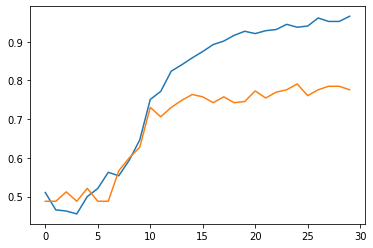

In [213]:
# Menampilkan grafik accuracy dan validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Tampilkan grafik yang telah diplot
plt.show()

In [174]:
# Menampilkan hasil evaluasi akhir
score,accuracy = model.evaluate(X_val, Y_val, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (accuracy))

330/1 - 1s - loss: 1.0117 - accuracy: 0.7848
score: 1.00
acc: 0.78


In [201]:
# Ubah hasil inputan kalimat ke dalam bentuk lower case
uhuy = 'i hate this'
kalimat = uhuy.lower()

# Hapus seluruh simbol dan ganti dengan string kosong (''), gunakan function re.sub
kalimat = re.sub(regex, '', kalimat)

# Ubah hasil inputan kedalam list/array
kalimat = [kalimat]

print(kalimat)

['i hate this']


In [202]:
# Ubah token menjadi sequence/angka2
test_kalimat = tokenizer.texts_to_sequences(kalimat)

# Lakukan padding, jika jumlah kata dalam artikel tidak sebanyak max_features maka diisi dengan angka (0)
test_kalimat = pad_sequences(test_kalimat, maxlen=X.shape[1])

In [203]:
labels = ['0','1']
# Ubah kalimat yang ingin diuji kedalam bentuk vector
vector = np.array([test_kalimat.flatten()])

# Prediksi label dari kalimat tersebut menggunakan function model.predict_classes()
y = model.predict_classes(vector)

print(labels[y[0]])

0
